In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from cycler import cycler
from pathlib import Path

from scipy.stats import chi2_contingency
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    GradientBoostingRegressor
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    classification_report,
    mean_absolute_error, 
    mean_squared_error, 
    precision_recall_fscore_support,
    r2_score,
    roc_auc_score, 
    roc_curve
)
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import compute_sample_weight

import importlib
import src.leadscore_plot
importlib.reload(src.leadscore_plot)

from src.leadscore_plot import (
    plot_distribuicao_faixa_predita,
    plot_histograma_leadscore,
    plot_comparativo_projecao_realidade,
    plot_probabilidade_conversao_vs_score
)

from src.leadscore_real_previsto import tabela_comparativa_por_lancamento

# Definição das paletas de cores
cores = plt.get_cmap('Accent').colors
ciclo_cores = cycler('color', cores)
plt.rc('axes', prop_cycle=ciclo_cores)

# Carregar dados
df_leads = pd.read_csv(r"C:\Users\Camilo_Bica\data_science\consultoria\portal_vhe\dados\pesquisa_captacao_com_email.csv")
df_alunos = pd.read_csv(r"C:\Users\Camilo_Bica\data_science\consultoria\portal_vhe\dados\pesquisa_alunos_leadscore.csv")

# Padronizar e-mails
df_leads["email"] = df_leads["email"].str.lower()
df_alunos["email"] = df_alunos["email"].str.lower()

# Criar target binário: comprou
df_leads["comprou"] = df_leads["email"].isin(df_alunos["email"]).astype(int)

In [2]:
"""
Esse bloco monta um modelo de classificação binária para prever a probabilidade de conversão de leads, com:

- Entrada: Perfil e respostas do lead
- Saída: Chance de virar aluno
- Algoritmo: Gradient Boosting
- Métrica usada: ROC AUC
"""

features_leads = [
    "genero", "faixa_etaria", "escolaridade_categoria", "renda_media", "profissao_categoria",
    "onde_acompanha_conteudo", "nivel_idioma", "fala_outro_idioma_categoria",
    "motivo_fluencia_espanhol_categoria", "problema_aprender_categoria",
    "investir_portal_vhe", "tempo_antes_redes_sociais", "fez_curso_espanhol", "ouviu_falar_portal_vhe"
]

X = pd.get_dummies(df_leads[features_leads], drop_first=False)
y = df_leads["comprou"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

modelo = GradientBoostingClassifier(random_state=42)
modelo.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, modelo.predict_proba(X_test)[:, 1])
print(f"ROC AUC (possível comprador): {roc_auc:.3f}")

ROC AUC (possível comprador): 0.794


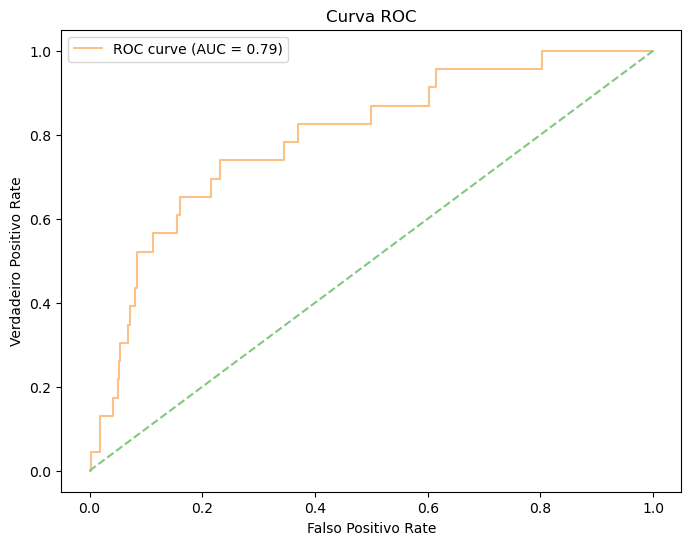

,Threshold,Precision,Recall,F1 Score
2,0.040816,0.104,0.522,0.174
3,0.061224,0.092,0.304,0.141
1,0.020408,0.068,0.652,0.122
5,0.102041,0.088,0.130,0.105
4,0.081633,0.073,0.174,0.103
6,0.122449,0.087,0.087,0.087
22,0.448980,0.250,0.043,0.074
23,0.469388,0.250,0.043,0.074
21,0.428571,0.250,0.043,0.074
20,0.408163,0.250,0.043,0.074


In [3]:
# Certifique-se de ter X_test, y_test e modelo treinado
probs = modelo.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Plotar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, probs):.2f})", color=cores[2])
plt.plot([0, 1], [0, 1], linestyle="--", color=cores[0])
plt.xlabel("Falso Positivo Rate")
plt.ylabel("Verdadeiro Positivo Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(False)
plt.show()

# Avaliação para thresholds de 0.0 até 1.0
thresholds_to_test = np.linspace(0, 1, 50)
metrics = []

for thresh in thresholds_to_test:
    y_pred = (probs >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    metrics.append((thresh, precision, recall, f1))

# Mostrar tabela de avaliação
df_thresholds = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1 Score"])
df_thresholds["F1 Score"] = df_thresholds["F1 Score"].round(3)
df_thresholds["Precision"] = df_thresholds["Precision"].round(3)
df_thresholds["Recall"] = df_thresholds["Recall"].round(3)
df_thresholds.sort_values("F1 Score", ascending=False).head(10)

In [4]:
"""
- Objetivo: Criar um modelo que aprenda o leadscore_total dos alunos.
- Motivo: Usar esse modelo para atribuir um score estimado para novos leads, mesmo sem saber se eles compraram.
- Vantagem: Isso permite aplicar o mesmo raciocínio de score em leads futuros.
"""

# Features para treinar
features_alunos = [
    "genero", "faixa_etaria", "escolaridade_categoria", "renda_media", "profissao_categoria",
    "onde_acompanha_conteudo", "nivel_idioma", "fala_outro_idioma_categoria",
    "motivo_fluencia_espanhol_categoria", "problema_aprender_categoria"
]

# Preparo dos dados
X_reg = pd.get_dummies(df_alunos[features_alunos], drop_first=False)
y_reg = df_alunos["leadscore_total"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, random_state=42)

# Modelo de regressão
modelo_reg = GradientBoostingRegressor(random_state=42)
modelo_reg.fit(X_train_r, y_train_r)

# Avaliação
y_pred = modelo_reg.predict(X_test_r)
mae = mean_absolute_error(y_test_r, y_pred)
r2 = r2_score(y_test_r, y_pred)

print(f"R²: {r2:.2f}")
print(f"Erro médio absoluto (MAE): {mae:.2f}")

R²: 0.98
Erro médio absoluto (MAE): 67.89


In [5]:
# Previsão nos leads
X_leads = pd.get_dummies(df_leads[features_leads], drop_first=False)
X_leads = X_leads.reindex(columns=X_reg.columns, fill_value=0)

# Gerar leadscore estimado contínuo
df_leads["leadscore_estimado_total"] = modelo_reg.predict(X_leads)
df_leads["leadscore_estimado_total"] = (df_leads["leadscore_estimado_total"]).round(2)

# Visualizar os top leads por score estimado
df_leads.sort_values("leadscore_estimado_total", ascending=False).head(10)

,data_inscricao,email,genero,faixa_etaria,renda_media,onde_acompanha_conteudo,tempo_antes_redes_sociais,nivel_idioma,fez_curso_espanhol,ouviu_falar_portal_vhe,investir_portal_vhe,lancamentos,problema_aprender_categoria,profissao_categoria,fala_outro_idioma_categoria,motivo_fluencia_espanhol_categoria,escolaridade_categoria,comprou,leadscore_estimado_total
480,2024-04-30,daninhabh70@gmail.com,Feminino,44 - 55,De 2.500 a 5.000,YouTube,Mais de 3 meses menos de 1 ano,Iniciante,Sim,Sim,"Posso investir até R$150,00 por mês",L3-24,Não sei por onde começar,Administrativo,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Pós-graduação completa,0,5387.14
4114,2025-01-17,pamelacris_pereira@hotmail.com,Feminino,25 - 34,De 2.500 a 5.000,Instagram,Menos de 2 semanas,Iniciante,"Não, nunca fiz.",Não,"Até R$200,00 por mês",L1-25,Timidez / medo de errar,Administrativo,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Pós-graduação completa,0,5365.95
1167,2024-05-05,lucienepaivams@gmail.com,Feminino,44 - 55,De 2.500 a 5.000,Instagram,Menos de 2 semanas,Iniciante,Sim,Não,"Posso investir até R$150,00 por mês",L3-24,Não sei por onde começar,Administrativo,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Pós-graduação completa,0,5358.22
745,2024-05-01,danielly.franco@gmail.com,Feminino,25 - 34,De 2.500 a 5.000,YouTube,Conheci hoje,Iniciante,Sim,Não,"Posso investir até R$150,00 por mês",L3-24,Falta de disciplina / foco,CLT,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Pós-graduação completa,0,5356.78
1089,2024-05-04,lumartinsdf@gmail.com,Feminino,35 - 44,De 2.500 a 5.000,Instagram,Mais de 1 mês e menos de 3 meses,Iniciante,Sim,Não,"Posso investir até R$150,00 por mês",L3-24,Falta de disciplina / foco,Administrativo,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Pós-graduação completa,0,5335.34
498,2024-04-30,senasuporte@hotmail.com,Feminino,35 - 44,De 2.500 a 5.000,Instagram,Conheci hoje,Iniciante,Não,Não,NaN,L3-24,Outros,Administrativo,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Pós-graduação completa,0,5330.83
4534,2025-01-21,lene8112@gmail.com,Feminino,44 - 55,De 2.500 a 5.000,YouTube,Mais de 3 meses menos de 1 ano,Iniciante,Fiz mas não concluí.,Não,"Até R$200,00 por mês",L1-25,Problemas financeiros,Administrativo,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Pós-graduação completa,0,5326.29
1723,2024-05-12,renataumbelino90@gmail.com,Feminino,25 - 34,De 2.500 a 5.000,Instagram,Conheci hoje,Iniciante,Não,Não,"Posso investir até R$150,00 por mês",L3-24,Falta de disciplina / foco,CLT,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Pós-graduação completa,0,5323.06
1058,2024-05-04,hebiene.bia@hotmail.com,Feminino,25 - 34,De 2.500 a 5.000,Instagram,Menos de 2 semanas,Iniciante,Não,Não,"Posso investir até R$150,00 por mês",L3-24,Falta de disciplina / foco,CLT,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Pós-graduação completa,0,5323.06
1388,2024-05-07,nadia_faculdade@hotmail.com,Feminino,25 - 34,De 2.500 a 5.000,Instagram,Menos de 2 semanas,Iniciante,Não,Não,Não tenho dinheiro para investir em curso,L3-24,Falta de método,Administrativo,Não Fala Outro Idioma,Conquistar um emprego melhor e ganhar mais,Pós-graduação completa,0,5320.86


In [6]:
# Usar a mesma lógica de faixas com base na média dos compradores
media_compradores = df_alunos["leadscore_total"].mean()
limite_a = media_compradores * 1.10
limite_b = media_compradores * 0.90
limite_c = media_compradores * 0.70
limite_d = media_compradores * 0.50

def classificar_faixa_por_media(score):
    if score >= limite_a:
        return "A"
    elif score >= limite_b:
        return "B"
    elif score >= limite_c:
        return "C"
    else:
        return "D"

# Aplicar nos leads
df_leads["faixa_predita_por_regressao"] = df_leads["leadscore_estimado_total"].apply(classificar_faixa_por_media)

# Ver distribuição
# Contagem absoluta e percentual
contagem = df_leads["faixa_predita_por_regressao"].value_counts()
percentual = df_leads["faixa_predita_por_regressao"].value_counts(normalize=True).round(3) * 100

# Junta os dois em um único DataFrame
resumo_faixas = pd.concat([contagem, percentual], axis=1)
resumo_faixas.columns = ["Total", "Percentual (%)"]

# Exibe tudo em uma linha por faixa
print(resumo_faixas.to_string())

                             Total  Percentual (%)
faixa_predita_por_regressao                       
B                             2253            49.3
C                             1545            33.8
A                              631            13.8
D                              139             3.0


In [7]:
# Leads por faixa prevista e por lançamento
tabela_leads_faixa = (
    df_leads
    .groupby(["lancamentos", "faixa_predita_por_regressao"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# Total por linha
tabela_leads_faixa["Total"] = tabela_leads_faixa.sum(axis=1)

# Total por coluna (linha final)
tabela_leads_faixa.loc["Total"] = tabela_leads_faixa.sum()

display(tabela_leads_faixa)

faixa_predita_por_regressao,A,B,C,D,Total
lancamentos,,,,,
L1-25,321,1345,1009,106,2781
L3-24,310,907,536,33,1786
L4-24,0,1,0,0,1
Total,631,2253,1545,139,4568


In [8]:
# Distribuição percentual das faixas por lançamento (usando nova faixa)
faixa_por_lancamento = (
    df_leads.groupby(["lancamentos", "faixa_predita_por_regressao"])
    .size()
    .unstack(fill_value=0)
)

# Proporção por lançamento
faixa_pct_por_lancamento = (
    faixa_por_lancamento.div(faixa_por_lancamento.sum(axis=1), axis=0).round(3) * 100
)

# Média do score estimado por lançamento
media_score = df_leads.groupby("lancamentos")["leadscore_estimado_total"].mean().round(2)

# Juntar em uma tabela final
tabela_lancamentos = faixa_pct_por_lancamento.copy()
tabela_lancamentos["leadscore_medio_estimado"] = media_score

# Exibir a tabela
tabela_lancamentos

faixa_predita_por_regressao,A,B,C,D,leadscore_medio_estimado
lancamentos,,,,,
L1-25,11.5,48.4,36.3,3.8,3928.46
L3-24,17.4,50.8,30.0,1.8,4058.94
L4-24,0.0,100.0,0.0,0.0,4139.90


In [9]:
tabela_alunos_faixa = (
    df_alunos
    .groupby("lancamentos")["leadscore_faixa"]
    .value_counts()
    .unstack(fill_value=0)
    .sort_index()
)

# Adiciona coluna Total
tabela_alunos_faixa["Total"] = tabela_alunos_faixa.sum(axis=1)

# Total por coluna (linha final)
tabela_alunos_faixa.loc["Total"] = tabela_alunos_faixa.sum()

display(tabela_alunos_faixa)

leadscore_faixa,A,B,C,D,Total
lancamentos,,,,,
L1-25,9,17,4,3,33
L3-24,72,145,55,5,277
L4-24,73,127,69,6,275
Total,154,289,128,14,585


In [10]:
# Seleciona leads com faixa A ou B
leads_quentes = df_leads[df_leads["faixa_predita_por_regressao"].isin(["A", "B"])]
total_quentes = leads_quentes.shape[0]

# Quantos desses já compraram
compraram_quentes = leads_quentes["comprou"].sum()

# Resultado
print(f"Leads classificados como A ou B: {total_quentes}")
print(f"Desses, já compraram: {compraram_quentes}")
print(f"Ainda não compraram: {total_quentes - compraram_quentes}")

Leads classificados como A ou B: 2884
Desses, já compraram: 74
Ainda não compraram: 2810


In [11]:
df_leads.head()

,data_inscricao,email,genero,faixa_etaria,renda_media,onde_acompanha_conteudo,tempo_antes_redes_sociais,nivel_idioma,fez_curso_espanhol,ouviu_falar_portal_vhe,investir_portal_vhe,lancamentos,problema_aprender_categoria,profissao_categoria,fala_outro_idioma_categoria,motivo_fluencia_espanhol_categoria,escolaridade_categoria,comprou,leadscore_estimado_total,faixa_predita_por_regressao
0,2024-04-21,rachelsoares.ramos@gmail.com,Feminino,44 - 55,De 5.000 a 10.000,YouTube,Mais de 1 mês e menos de 3 meses,Iniciante,Não,Sim,"Posso investir até R$150,00 por mês",L3-24,Não sei por onde começar,Administrativo,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Superior completo,0,4967.13,A
1,2024-04-22,dariellymaelly71@gmail.com,Feminino,18 - 24,Até 1.500,Instagram,Conheci hoje,Intermediário,Não,Não,Não tenho dinheiro para investir em curso,L3-24,Falta de disciplina / foco,Administrativo,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Médio completo,0,3790.96,B
2,2024-04-22,paolabarretobs@gmail.com,Feminino,25 - 34,Não tenho renda,Instagram,Conheci hoje,Intermediário,Não,Não,Não tenho dinheiro para investir em curso,L3-24,Dificuldade com pronúncia,Desempregado,Não Fala Outro Idioma,Intercâmbio,Superior completo,0,4184.47,B
3,2024-04-22,victoria_san_oliveira@hotmail.com,Feminino,25 - 34,De 2.500 a 5.000,Instagram,Mais de 3 meses menos de 1 ano,Intermediário,Sim,Não,"Posso investir até R$150,00 por mês",L3-24,Falta de método,Empreendedorismo,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Pós-graduação completa,0,4957.11,A
4,2024-04-22,patyn.leite@gmail.com,Feminino,44 - 55,De 1.500 a 2.500,YouTube,Menos de 2 semanas,Iniciante,Sim,Não,"Posso investir entre R$150,00 - R$250,00 por mês",L3-24,Dificuldade com pronúncia,Empreendedorismo,Inglês Intermediário ou Avançado,Morar no exterior,Superior completo,0,3972.58,B


In [12]:
"""
Esse bloco valida a capacidade do modelo de regressão de classificar 
corretamente os alunos em faixas, mesmo sem ter sido treinado com a 
variável categórica.

Ele mostra que o modelo realmente aprendeu uma estrutura lógica coerente 
com o que foi atribuído manualmente, e que pode ser usado com confiança nos leads.
"""

# Juntar previsão do modelo de regressão com o leadscore real dos alunos
df_avaliacao = df_alunos[["email", "leadscore_total", "leadscore_faixa"]].copy()

# Aplicar modelo para prever score total
X_alunos = pd.get_dummies(df_alunos[features_alunos], drop_first=False)
X_alunos = X_alunos.reindex(columns=X_reg.columns, fill_value=0)

df_avaliacao["score_estimado"] = modelo_reg.predict(X_alunos)

# Reaplicar função de faixa com base no score estimado
df_avaliacao["faixa_estimada"] = df_avaliacao["score_estimado"].apply(classificar_faixa_por_media)

# Comparar real vs predito
comparativo = df_avaliacao.groupby(["leadscore_faixa", "faixa_estimada"]).size().unstack(fill_value=0)

display(comparativo)

faixa_estimada,A,B,C,D
leadscore_faixa,,,,
A,146,8,0,0
B,4,279,6,0
C,0,6,122,0
D,0,0,3,11


In [13]:
# Passo 1: Contagem de faixas previstas para TODOS os leads válidos
contagem_prevista = df_leads["faixa_predita_por_regressao"].value_counts(normalize=True).sort_index() * 100

# Passo 2: Contagem REAL de faixas entre leads que viraram alunos
contagem_real = df_alunos["leadscore_faixa"].value_counts(normalize=True).sort_index() * 100

# Montar tabela comparativa
comparativo_perc = pd.DataFrame({
    "Projeção (%) entre Leads": contagem_prevista,
    "Realidade (%) entre Alunos": contagem_real
}).fillna(0).round(1)

# Calcular variação percentual
comparativo_perc["Variação (p.p.)"] = (
    comparativo_perc["Projeção (%) entre Leads"] - comparativo_perc["Realidade (%) entre Alunos"]
).round(1)

# Exibir
display(comparativo_perc)

,Projeção (%) entre Leads,Realidade (%) entre Alunos,Variação (p.p.)
A,13.8,26.3,-12.5
B,49.3,49.4,-0.1
C,33.8,21.9,11.9
D,3.0,2.4,0.6


In [14]:
# Juntar respostas duplicadas (mesma pessoa respondeu como lead e como aluno)
comparacao = df_leads.merge(
    df_alunos,
    on="email",
    suffixes=("_lead", "_aluno")
)

# Verificar onde as respostas foram diferentes
mudancas = {}
for var in features_alunos:
    col_lead = f"{var}_lead"
    col_aluno = f"{var}_aluno"
    diferentes = (comparacao[col_lead] != comparacao[col_aluno]).sum()
    total = comparacao.shape[0]
    mudancas[var] = round((diferentes / total) * 100, 1)

# Transformar em DataFrame para exibição
df_mudancas = pd.DataFrame.from_dict(mudancas, orient="index", columns=["% Respostas Diferentes"])
df_mudancas.sort_values(by="% Respostas Diferentes", ascending=False, inplace=True)

df_mudancas

,% Respostas Diferentes
profissao_categoria,86.0
problema_aprender_categoria,59.1
renda_media,41.9
motivo_fluencia_espanhol_categoria,40.9
nivel_idioma,36.6
onde_acompanha_conteudo,31.2
escolaridade_categoria,12.9
fala_outro_idioma_categoria,7.5
faixa_etaria,5.4
genero,2.2


In [15]:
# Para cada variável comum, mostra quantas respostas mudaram e exibe os primeiros exemplos
for var in features_alunos:
    col_lead = f"{var}_lead"
    col_aluno = f"{var}_aluno"
    
    diferentes = comparacao[comparacao[col_lead] != comparacao[col_aluno]]
    total = comparacao.shape[0]
    
    print(f"\n🔍 {len(diferentes)} de {total} respostas são diferentes em '{var}'")
    display(diferentes[["email", col_lead, col_aluno]].head(10))


🔍 2 de 93 respostas são diferentes em 'genero'


,email,genero_lead,genero_aluno
31,leonepsanches@gmail.com,Prefiro não responder,Feminino
86,joaofurtadon@gmail.com,Feminino,Masculino



🔍 5 de 93 respostas são diferentes em 'faixa_etaria'


,email,faixa_etaria_lead,faixa_etaria_aluno
4,nicolevalverde843@gmail.com,14 - 17,18 - 24
6,cxl.milla@icloud.com,25 - 34,35 - 44
30,fabiane_souza2007@hotmail.com,25 - 34,35 - 44
51,corretoramauralima@gmail.com,+55,44 - 55
70,alesepul2008@gmail.com,35 - 44,44 - 55



🔍 12 de 93 respostas são diferentes em 'escolaridade_categoria'


,email,escolaridade_categoria_lead,escolaridade_categoria_aluno
0,bertholdkarolini@gmail.com,Médio completo,Médio incompleto
2,marcelaalencar35@gmail.com,Pós-graduação completa,Superior incompleto
7,emersonaugusto1974@gmail.com,Superior completo,Pós-graduação completa
9,mviana.rosangela@gmail.com,Médio completo,Superior incompleto
30,fabiane_souza2007@hotmail.com,Fundamental completo,Médio incompleto
31,leonepsanches@gmail.com,Médio completo,Superior incompleto
34,apfagundesm@gmail.com,Superior completo,Superior incompleto
51,corretoramauralima@gmail.com,Médio completo,Superior incompleto
58,raicaalves@bol.com.br,Médio completo,Superior incompleto
62,liligama50@gmail.com,Médio completo,Superior incompleto



🔍 39 de 93 respostas são diferentes em 'renda_media'


,email,renda_media_lead,renda_media_aluno
1,isabelclaudio.claudio@gmail.com,De 2.500 a 5.000,Mais de 10.000
5,marcelobds0163@gmail.com,De 2.500 a 5.000,De 5.000 a 10.000
7,emersonaugusto1974@gmail.com,De 2.500 a 5.000,De 5.000 a 10.000
12,jullya.anf00@gmail.com,Não tenho renda,Não tenho renda.
13,marcelofcoelho@outlook.com,Até 1.500,De 1.500 a 2.500
14,giselebarbosa366@gmail.com,Não tenho renda,Até 1.500
17,pamella.m.ferreira@gmail.com,De 2.500 a 5.000,De 5.000 a 10.000
18,sergiobozato@gmail.com,De 2.500 a 5.000,De 5.000 a 10.000
19,mercia.andrea90@gmail.com,De 5.000 a 10.000,De 2.500 a 5.000
22,leticialobolsl@gmail.com,De 1.500 a 2.500,De 2.500 a 5.000



🔍 80 de 93 respostas são diferentes em 'profissao_categoria'


,email,profissao_categoria_lead,profissao_categoria_aluno
0,bertholdkarolini@gmail.com,Empreendedorismo,Beleza
2,marcelaalencar35@gmail.com,CLT,Administrativo
3,souza.vmp@gmail.com,CLT,Arquitetura-Engenharia
4,nicolevalverde843@gmail.com,CLT,Técnico Operacional
6,cxl.milla@icloud.com,CLT,Administrativo
7,emersonaugusto1974@gmail.com,Administrativo,Segurança
8,dra.mariarosa@yahoo.com.br,Aposentado,Saúde
10,flaviamoreira1212@gmail.com,CLT,Vendas
11,al.rodrigues.psi@gmail.com,Empreendedorismo,Saúde
12,jullya.anf00@gmail.com,Desempregado,Publicidade



🔍 29 de 93 respostas são diferentes em 'onde_acompanha_conteudo'


,email,onde_acompanha_conteudo_lead,onde_acompanha_conteudo_aluno
0,bertholdkarolini@gmail.com,YouTube,Instagram
4,nicolevalverde843@gmail.com,Não acompanhava,Instagram
5,marcelobds0163@gmail.com,Não acompanhava,Instagram
10,flaviamoreira1212@gmail.com,Instagram,YouTube
13,marcelofcoelho@outlook.com,Instagram,YouTube
18,sergiobozato@gmail.com,YouTube,Instagram
19,mercia.andrea90@gmail.com,Instagram,YouTube
20,fatimaqueiroz1@outlook.com,Não acompanhava,Instagram
34,apfagundesm@gmail.com,Não acompanhava,YouTube
37,clareana@me.com,Não acompanhava,Instagram



🔍 34 de 93 respostas são diferentes em 'nivel_idioma'


,email,nivel_idioma_lead,nivel_idioma_aluno
2,marcelaalencar35@gmail.com,Intermediário,Iniciante
5,marcelobds0163@gmail.com,Perdido,Iniciante
8,dra.mariarosa@yahoo.com.br,Intermediário,Iniciante
10,flaviamoreira1212@gmail.com,Perdido,Iniciante
11,al.rodrigues.psi@gmail.com,Iniciante,Intermediário
13,marcelofcoelho@outlook.com,Perdido,Iniciante
15,gyseletamires@gmail.com,Intermediário,Iniciante
16,oliveiragianni@yahoo.com.br,Intermediário,Iniciante
22,leticialobolsl@gmail.com,Intermediário,Iniciante
23,cecilia_luli@yahoo.com.br,Intermediário,Iniciante



🔍 7 de 93 respostas são diferentes em 'fala_outro_idioma_categoria'


,email,fala_outro_idioma_categoria_lead,fala_outro_idioma_categoria_aluno
15,gyseletamires@gmail.com,Inglês Intermediário ou Avançado,Não Fala Outro Idioma
40,juninhocosta000@gmail.com,Inglês Básico,Espanhol
63,edeilsongc38@gmail.com,Inglês Intermediário ou Avançado,Não Fala Outro Idioma
65,humbaline@gmail.com,Não Fala Outro Idioma,Inglês Básico
70,alesepul2008@gmail.com,Não Fala Outro Idioma,Inglês Intermediário ou Avançado
72,xavieradvoc@bol.com.br,Não Fala Outro Idioma,Inglês Intermediário ou Avançado
91,marcelfernandes23@gmail.com,Não Fala Outro Idioma,Inglês Básico



🔍 38 de 93 respostas são diferentes em 'motivo_fluencia_espanhol_categoria'


,email,motivo_fluencia_espanhol_categoria_lead,motivo_fluencia_espanhol_categoria_aluno
0,bertholdkarolini@gmail.com,Quero viajar e viver experiências marcantes me...,Intercâmbio
2,marcelaalencar35@gmail.com,Morar no exterior,Quero viajar e viver experiências marcantes me...
4,nicolevalverde843@gmail.com,Quero viajar e viver experiências marcantes me...,Conquistar um emprego melhor e ganhar mais
7,emersonaugusto1974@gmail.com,Prova de Proficiência,Conquistar um emprego melhor e ganhar mais
10,flaviamoreira1212@gmail.com,Quero viajar e viver experiências marcantes me...,Conquistar um emprego melhor e ganhar mais
12,jullya.anf00@gmail.com,Quero viajar e viver experiências marcantes me...,Conquistar um emprego melhor e ganhar mais
14,giselebarbosa366@gmail.com,Quero viajar e viver experiências marcantes me...,Voluntariado
15,gyseletamires@gmail.com,Conquistar um emprego melhor e ganhar mais,Quero viajar e viver experiências marcantes me...
17,pamella.m.ferreira@gmail.com,Quero viajar e viver experiências marcantes me...,Conquistar um emprego melhor e ganhar mais
18,sergiobozato@gmail.com,Quero viajar e viver experiências marcantes me...,Família



🔍 55 de 93 respostas são diferentes em 'problema_aprender_categoria'


,email,problema_aprender_categoria_lead,problema_aprender_categoria_aluno
3,souza.vmp@gmail.com,Falta de disciplina / foco,Falta de método
4,nicolevalverde843@gmail.com,Falta de método,Falta de tempo
5,marcelobds0163@gmail.com,Dificuldade com pronúncia,Falta de tempo
9,mviana.rosangela@gmail.com,Falta de método,Falta de tempo
10,flaviamoreira1212@gmail.com,Falta de disciplina / foco,Não sei por onde começar
12,jullya.anf00@gmail.com,Não sei por onde começar,Falta de disciplina / foco
13,marcelofcoelho@outlook.com,Não sei por onde começar,Falta de tempo
14,giselebarbosa366@gmail.com,Timidez / medo de errar,Falta de disciplina / foco
16,oliveiragianni@yahoo.com.br,Dificuldade com pronúncia,Falta de método
20,fatimaqueiroz1@outlook.com,Falta de método,Dificuldade com pronúncia


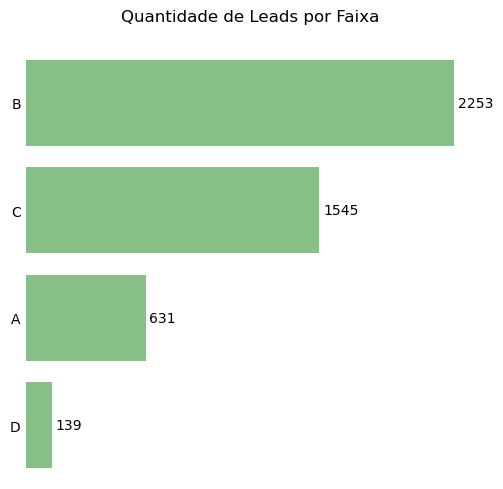

In [16]:
plot_distribuicao_faixa_predita(df_leads)

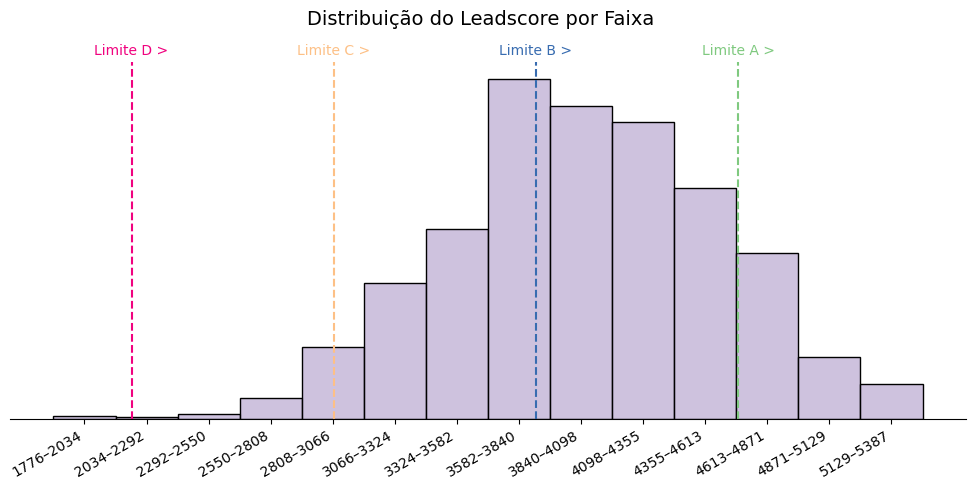

In [17]:
plot_histograma_leadscore(df_leads, limite_a, limite_b, limite_c, limite_d)

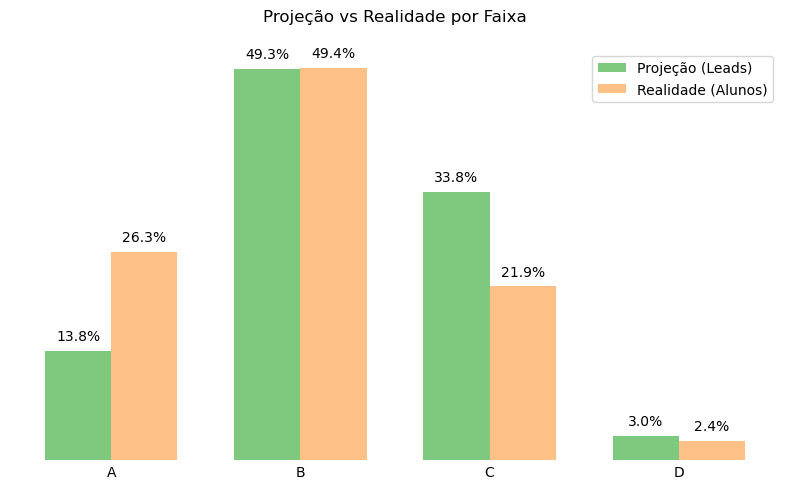

In [18]:
plot_comparativo_projecao_realidade(df_leads, df_alunos)

In [19]:
tabela_comparativa_por_lancamento(df_leads, df_alunos)

,,A_previsto,A_real,A_variação,B_previsto,B_real,B_variação,C_previsto,C_real,C_variação,D_previsto,D_real,D_variação
lancamentos,lancamentos,,,,,,,,,,,,
L1-25,L1-25,11.5%,27.3%,-15.8%,48.4%,51.5%,-3.1%,36.3%,12.1%,24.2%,3.8%,9.1%,-5.3%
L3-24,L3-24,17.4%,26.0%,-8.6%,50.8%,52.3%,-1.5%,30.0%,19.9%,10.1%,1.8%,1.8%,0.0%
L4-24,L4-24,0.0%,26.5%,-26.5%,100.0%,46.2%,53.8%,0.0%,25.1%,-25.1%,0.0%,2.2%,-2.2%


In [20]:
"""
Esse modelo é o coração da previsão de probabilidade de conversão. E ele tem duas grandes vantagens:

1. Calibração com pesos → ajuda a lidar com o desbalanceamento real
2. Integração com o score → junta perfil sociodemográfico + quão parecido o lead é com os alunos
"""

# Preparar X e y
X = pd.get_dummies(df_leads[features_leads], drop_first=False)
X["leadscore_total"] = df_leads["leadscore_estimado_total"]  # Adiciona o score como feature
y = df_leads["comprou"]

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

modelo_calibrado = GradientBoostingClassifier(random_state=42)
modelo_calibrado.fit(X_train, y_train, sample_weight=sample_weight)

# Score calibrado com base nas duas fontes
df_leads["probabilidade_conversao_calibrada"] = modelo_calibrado.predict_proba(X)[:, 1]

# Avaliação
print("ROC AUC:", roc_auc_score(y_test, modelo_calibrado.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, modelo_calibrado.predict(X_test)))

ROC AUC: 0.7434432917589462
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1119
           1       0.07      0.39      0.12        23

    accuracy                           0.88      1142
   macro avg       0.53      0.64      0.53      1142
weighted avg       0.97      0.88      0.92      1142



In [21]:
"""
Objetivo desse trecho: Criar um score final que combina

- A semelhança do lead com alunos (via score estimado)
- A probabilidade real de conversão (via modelo supervisionado)
"""

# Normalizar ambos para percentuais
score_pct = df_leads["leadscore_estimado_total"].rank(pct=True)
conv_prob = df_leads["probabilidade_conversao_calibrada"]

# Score híbrido
df_leads["score_hibrido"] = ((score_pct + conv_prob) / 2).round(4)

# Ordenar leads com base no score híbrido
leads_rankeados = df_leads.sort_values("score_hibrido", ascending=False)

df_leads.head()

,data_inscricao,email,genero,faixa_etaria,renda_media,onde_acompanha_conteudo,tempo_antes_redes_sociais,nivel_idioma,fez_curso_espanhol,ouviu_falar_portal_vhe,...,problema_aprender_categoria,profissao_categoria,fala_outro_idioma_categoria,motivo_fluencia_espanhol_categoria,escolaridade_categoria,comprou,leadscore_estimado_total,faixa_predita_por_regressao,probabilidade_conversao_calibrada,score_hibrido
0,2024-04-21,rachelsoares.ramos@gmail.com,Feminino,44 - 55,De 5.000 a 10.000,YouTube,Mais de 1 mês e menos de 3 meses,Iniciante,Não,Sim,...,Não sei por onde começar,Administrativo,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Superior completo,0,4967.13,A,0.681184,0.8220
1,2024-04-22,dariellymaelly71@gmail.com,Feminino,18 - 24,Até 1.500,Instagram,Conheci hoje,Intermediário,Não,Não,...,Falta de disciplina / foco,Administrativo,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Médio completo,0,3790.96,B,0.151719,0.2637
2,2024-04-22,paolabarretobs@gmail.com,Feminino,25 - 34,Não tenho renda,Instagram,Conheci hoje,Intermediário,Não,Não,...,Dificuldade com pronúncia,Desempregado,Não Fala Outro Idioma,Intercâmbio,Superior completo,0,4184.47,B,0.224070,0.4304
3,2024-04-22,victoria_san_oliveira@hotmail.com,Feminino,25 - 34,De 2.500 a 5.000,Instagram,Mais de 3 meses menos de 1 ano,Intermediário,Sim,Não,...,Falta de método,Empreendedorismo,Não Fala Outro Idioma,Quero viajar e viver experiências marcantes me...,Pós-graduação completa,0,4957.11,A,0.868274,0.9145
4,2024-04-22,patyn.leite@gmail.com,Feminino,44 - 55,De 1.500 a 2.500,YouTube,Menos de 2 semanas,Iniciante,Sim,Não,...,Dificuldade com pronúncia,Empreendedorismo,Inglês Intermediário ou Avançado,Morar no exterior,Superior completo,0,3972.58,B,0.851484,0.6767


In [22]:
# 📋 Lista das colunas desejadas
colunas_desejadas = [
    "email",
    "comprou",
    "leadscore_estimado_total",
    "faixa_predita_por_regressao",
    "probabilidade_conversao_calibrada",
    "score_hibrido"
]

# 🧾 Filtrar e exibir o DataFrame com as colunas desejadas
df_resumo = df_leads[colunas_desejadas].copy()
display(df_resumo.head(30))

,email,comprou,leadscore_estimado_total,faixa_predita_por_regressao,probabilidade_conversao_calibrada,score_hibrido
0,rachelsoares.ramos@gmail.com,0,4967.13,A,0.681184,0.8220
1,dariellymaelly71@gmail.com,0,3790.96,B,0.151719,0.2637
2,paolabarretobs@gmail.com,0,4184.47,B,0.224070,0.4304
3,victoria_san_oliveira@hotmail.com,0,4957.11,A,0.868274,0.9145
4,patyn.leite@gmail.com,0,3972.58,B,0.851484,0.6767
5,schiavinatosilva@gmail.com,0,3866.89,B,0.184080,0.3070
6,kelinesilvestre@gmail.com,0,4345.06,B,0.570480,0.6514
7,giovanaferlima5@gmail.com,0,3640.54,C,0.633929,0.4523
8,bertholdkarolini@gmail.com,1,3995.37,B,0.733154,0.6250
9,kemustafa@gmail.com,0,3144.50,C,0.513943,0.2968


In [23]:
# Calcular média do score híbrido por lançamento
media_hibrido_por_lancamento = (
    df_leads.groupby("lancamentos")["score_hibrido"]
    .mean()
    .mul(100)
    .round(1)
    .reset_index()
    .rename(columns={"score_hibrido": "probabilidade_media_conversao (%)"})
)

display(media_hibrido_por_lancamento)

,lancamentos,probabilidade_media_conversao (%)
0,L1-25,29.6
1,L3-24,44.4
2,L4-24,43.9


In [24]:
# Calcular média do score híbrido por lançamento
media_prob_conversao_por_lancamento = (
    df_leads.groupby("lancamentos")["probabilidade_conversao_calibrada"]
    .mean()
    .mul(100)
    .round(1)
    .reset_index()
    .rename(columns={"probabilidade_conversao_calibrada": "probabilidade_media_conversao (%)"})
)

display(media_prob_conversao_por_lancamento)

,lancamentos,probabilidade_media_conversao (%)
0,L1-25,11.6
1,L3-24,35.0
2,L4-24,27.0


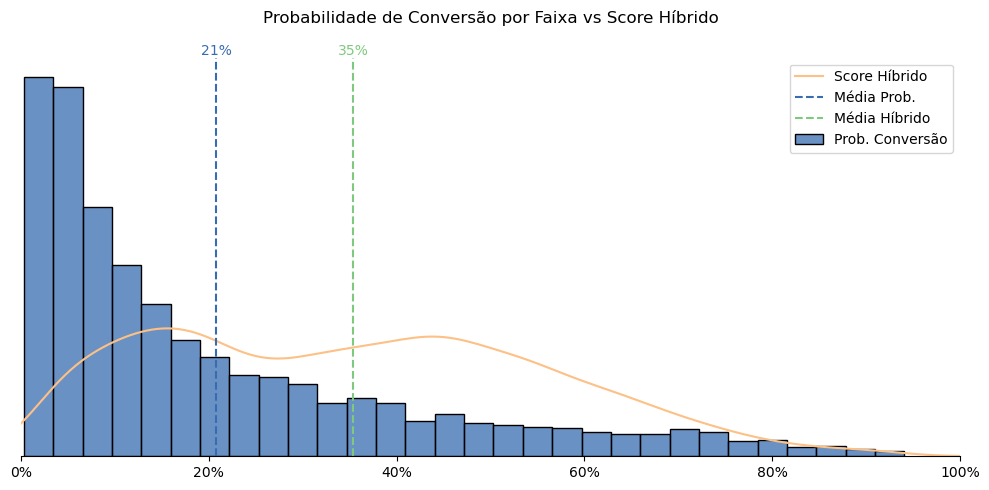

In [25]:
plot_probabilidade_conversao_vs_score(df_leads)

In [26]:
# Certifique-se de que esses limites estão definidos
limite_a = df_leads[df_leads["comprou"] == 1]["score_hibrido"].mean() * 1.10
limite_b = df_leads[df_leads["comprou"] == 1]["score_hibrido"].mean() * 0.90
limite_c = df_leads[df_leads["comprou"] == 1]["score_hibrido"].mean() * 0.70

# Sua função já existente
def classificar_faixa_por_media(score):
    if score >= limite_a:
        return "A"
    elif score >= limite_b:
        return "B"
    elif score >= limite_c:
        return "C"
    else:
        return "D"

# Aplicar a função no score_hibrido
df_leads["faixa_score_hibrido"] = df_leads["score_hibrido"].apply(classificar_faixa_por_media)


# Gerar a tabela
tabela_faixas_hibrido = (
    df_leads
    .groupby("faixa_score_hibrido")["comprou"]
    .agg(["count", "sum", "mean"])
    .rename(columns={
        "count": "Total Leads", 
        "sum": "Alunos", 
        "mean": "Taxa de Conversão"
    })
    .sort_index()
    .round(4)
)

# Formatar Taxa de Conversão como string percentual
tabela_faixas_hibrido["Taxa de Conversão (%)"] = (tabela_faixas_hibrido["Taxa de Conversão"] * 100).round(1).astype(str) + "%"

# Opcional: remover a coluna bruta se quiser mostrar só formatada
tabela_faixas_hibrido = tabela_faixas_hibrido.drop(columns="Taxa de Conversão")

# Exibir
display(tabela_faixas_hibrido)

,Total Leads,Alunos,Taxa de Conversão (%)
faixa_score_hibrido,,,
A,181,39,21.6%
B,473,29,6.1%
C,810,11,1.4%
D,3104,14,0.4%


In [27]:
leads_por_lancamento = (
    df_leads
    .groupby(["lancamentos", "faixa_score_hibrido"])
    .size()
    .unstack(fill_value=0)
)

leads_por_lancamento["Total"] = leads_por_lancamento.sum(axis=1)
display(leads_por_lancamento)

faixa_score_hibrido,A,B,C,D,Total
lancamentos,,,,,
L1-25,24,105,429,2223,2781
L3-24,157,368,381,880,1786
L4-24,0,0,0,1,1


In [28]:
# Comparar faixas entre leads que viraram alunos
df_compare = df_leads[df_leads["email"].isin(df_alunos["email"])][["email", "faixa_score_hibrido"]]
df_compare = df_compare.merge(
    df_alunos[["email", "leadscore_faixa"]],
    on="email"
)

# Tabela cruzada de faixas reais vs preditas
comparativo_faixa = pd.crosstab(df_compare["leadscore_faixa"], df_compare["faixa_score_hibrido"])
comparativo_faixa["Total"] = comparativo_faixa.sum(axis=1)

# Calcular % Acerto (diagonal / total da linha) e formatar como string com "%"
acertos = []
for idx in comparativo_faixa.index:
    if idx in comparativo_faixa.columns:
        correto = comparativo_faixa.loc[idx, idx]
    else:
        correto = 0
    total = comparativo_faixa.loc[idx, "Total"]
    acerto_pct = f"{round((correto / total) * 100):.0f}%" if total > 0 else "0%"
    acertos.append(acerto_pct)

# Adicionar coluna de % Acerto
comparativo_faixa["% Acerto"] = acertos

# ➤ Linha total: somar somente colunas numéricas (exclui % Acerto)
linha_total = comparativo_faixa.drop(columns="% Acerto").sum(numeric_only=True)
linha_total["% Acerto"] = ""

# Adicionar a linha Total
comparativo_faixa.loc["Total"] = linha_total

# Converter colunas numéricas para int
for col in comparativo_faixa.columns[:-2]:  # ignora "Total" e "% Acerto"
    comparativo_faixa[col] = comparativo_faixa[col].astype(int)
comparativo_faixa["Total"] = comparativo_faixa["Total"].astype(int)

# Exibir
display(comparativo_faixa)

faixa_score_hibrido,A,B,C,D,Total,% Acerto
leadscore_faixa,,,,,,
A,22,3,0,0,25,88%
B,16,20,7,5,48,42%
C,1,6,2,8,17,12%
D,0,0,2,1,3,33%
Total,39,29,11,14,93,


In [29]:
# Função Cramér's V
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Selecionar somente colunas e linhas válidas para a matriz de confusão
# Ignora a linha "Total" e a coluna "% Acerto"
conf_matrix = comparativo_faixa.drop(index="Total", errors="ignore")
conf_matrix = conf_matrix.drop(columns=["Total", "% Acerto"], errors="ignore")

# Garantir que todos os valores são inteiros (ou floats)
conf_matrix = conf_matrix.astype(int)

# Calcular Cramér’s V
cramers_v_score = cramers_v(conf_matrix)
print(f"Cramér’s V: {cramers_v_score:.3f} (0=sem associação, 1=perfeita)")

Cramér’s V: 0.437 (0=sem associação, 1=perfeita)


In [30]:
# Caminho da pasta raiz do projeto
path_projeto = Path().resolve().parent
path_modelos = path_projeto / "modelos"

# Salvar o modelo de regressão com faixa de classificação
joblib.dump(modelo_reg, path_modelos / "modelo_regressao_leadscore_total.pkl")
joblib.dump(X_reg.columns.tolist(), path_modelos / "colunas_regressao.pkl")

limites = {
    "media_compradores": media_compradores,
    "limite_a": limite_a,
    "limite_b": limite_b,
    "limite_c": limite_c,
    "limite_d": limite_d
}
joblib.dump(limites, path_modelos / "limites_faixa.pkl")

# Salvar o modelo calibrado de conversão
joblib.dump(modelo_calibrado, path_modelos / "modelo_conversao_calibrado.pkl")

# Salvar as colunas usadas nesse modelo (inclui leadscore_total)
joblib.dump(X.columns.tolist(), path_modelos / "colunas_modelo_conversao_calibrado.pkl")

print("✅ Arquivos salvos em:", path_modelos)

✅ Arquivos salvos em: C:\Users\Camilo_Bica\data_science\consultoria\portal_vhe\modelos


In [31]:
# Sobe um nível até a raiz do projeto e define a pasta 'dados'
pasta_dados = Path().resolve().parent / "dados"

# Salva o CSV no local correto
df_leads.to_csv(pasta_dados / "leads_completo_com_score_e_faixa.csv", index=False)
print(f"✅ Arquivo salvo em: {pasta_dados / 'leads_completo_com_score_e_faixa.csv'}")

✅ Arquivo salvo em: C:\Users\Camilo_Bica\data_science\consultoria\portal_vhe\dados\leads_completo_com_score_e_faixa.csv
